<h1 style="font-size:3em; text-align: center">Multi-Step Forecasting With Facebook's Prophet</h1>


In [2]:
# imports
import numpy             as np
import matplotlib.pyplot as plt
import pandas            as pd
import math
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras        import backend as K
from datetime     import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics       import mean_squared_error
from matplotlib.pylab      import rcParams
%matplotlib inline
rcParams['figure.figsize'] = 15, 6
# fixes the random number seed to ensure reproducible results
np.random.seed(69)

# number of inputs to be fed
look_back = 288
# number of outputs to be generated
look_forward = 24

Loss Function that Penalizes Over-Estimates Inspired from <br/>
https://datascience.stackexchange.com/questions/10471/linear-regression-with-non-symmetric-cost-function

Epoch 1/5
6s - loss: 0.0047
Epoch 2/5
6s - loss: 0.0028
Epoch 3/5
6s - loss: 0.0024
Epoch 4/5
6s - loss: 0.0023
Epoch 5/5
6s - loss: 0.0021


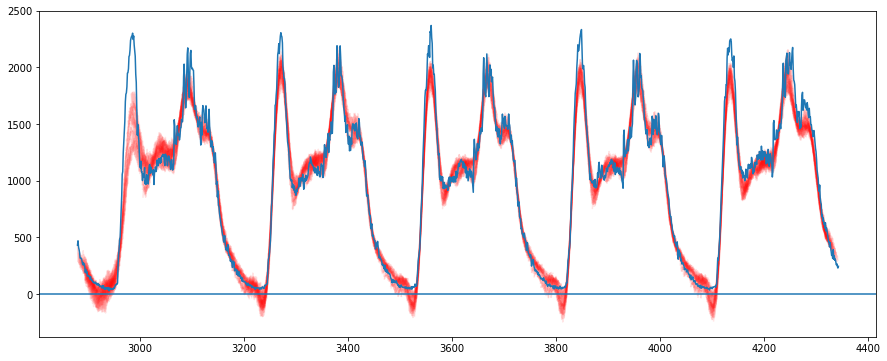

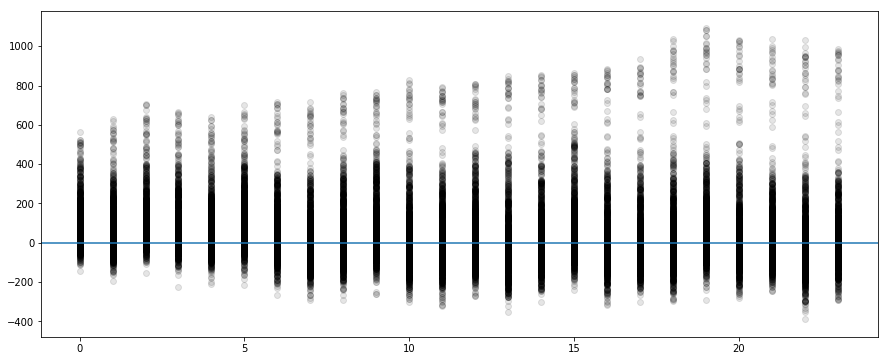

42.7864583333


In [3]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# log the dataset
#dataset = np.log(dataset_orig)
#dataset_max = max(dataset)
# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)
# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # normalize
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    prediction = scaler.inverse_transform(prediction)
    return prediction

def predict (day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    true_vals = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(look_forward)
        # plots the predictions
        plt.plot(range(point, point+look_forward),prediction,color='red', alpha=0.1)
        predictions = np.append(predictions, prediction)
        true_vals  = np.append(true_vals,dataset_orig[point:point+look_forward])
    # Reshapes the predictions and true vals to calculate the error
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    true_vals   = true_vals.reshape(len(true_vals)/look_forward, look_forward)
    plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
    plt.axhline(0)
    plt.show()
    if show_gradual_error:
        total = 0
        num_overestimating = 0
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            for j in range(len(indiv_err)):
                total += 1.0
                if (predictions[j, i] > true_vals[j, i]):
                    num_overestimating += 1.0
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
        print num_overestimating / total * 100
    
def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.55) #* ( ( K.sign(y_pred) * (K.sign(y_pred) - 1) ) * 4.5 + 1 )

b = 1
seed = 11

np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=(1, look_back)))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(64))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0002, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
predict(total_days=5,day=10,delta=1)

In [ ]:
look_forward = 24
look_back = 288
# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset_orig)

# split into train and test sets
train_size = 288*10
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)
# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

def predict_with_uncertainty(f, dataset, n_iter=10):
    result = np.zeros((n_iter,) + (1,look_forward,))
    for iter in range(n_iter):
        result[iter] = f([dataset, 1])
    prediction = result.mean(axis=0)
    uncertainty = result.var(axis=0)
    return prediction, uncertainty


# If f is defined, this returns an array
def predictNext2Hours (model, dataset, f=None):
    
    dataset = np.array(dataset)
    # normalize
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    
    if f is None:
        # make a prediction
        prediction = model.predict(data)
        prediction = scaler.inverse_transform(prediction)
        return prediction
    else:
        prediction, uncertainty = predict_with_uncertainty(f, data)
        prediction = scaler.inverse_transform(prediction)
        uncertainty = scaler.inverse_transform(uncertainty)
        return prediction, uncertainty
    

def predict (f=None, day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    uncertainties = np.array([])
    true_vals   = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        
        if f is None:
            prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(look_forward)
        else:
            prediction, uncertainty = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back), f=f)
            prediction = prediction.reshape(look_forward)
            uncertainty = uncertainty.reshape(look_forward)
        
        # plots the predictions
        plt.plot(range(point, point+look_forward),prediction,color='red', alpha=0.1)
        
        predictions = np.append(predictions, prediction)
        uncertainties = np.append (uncertainties, uncertainty)
        true_vals  = np.append(true_vals,dataset_orig[point:point+look_forward])
    # Reshapes the predictions and true vals to calculate the error
    predictions = predictions.reshape(len(predictions)/look_forward, look_forward)
    uncertainties = uncertainties.reshape(len(uncertainties)/look_forward, look_forward)
    true_vals   = true_vals.reshape(len(true_vals)/look_forward, look_forward)
    plt.plot( np.arange(288*total_days+look_forward) + 288 * day, dataset_orig[288*day:288*day+288*total_days + look_forward,0])
    plt.axhline(0)
    plt.show()
    if show_gradual_error:
        total = 0
        num_overestimating = 0
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            for j in range(len(indiv_err)):
                total += 1.0
                if (predictions[j, i] > true_vals[j, i]):
                    num_overestimating += 1.0
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        plt.axhline(0)
        plt.show()
        print num_overestimating / total * 100
        
        print np.mean(uncertainties, axis=0)
    
def over_penalty(y_true, y_pred):
    true_error = y_true - y_pred
    # doubles the error if the prediction is negative
    return  K.square(true_error) * K.square(K.sign(true_error) - 0.55) #* ( ( K.sign(y_pred) * (K.sign(y_pred) - 1) ) * 4.5 + 1 )


b = 1
seed = 11
rate = 0.2
print '0.2'
np.random.seed(seed)
# create and fit the LSTM network
model = Sequential()
model.add(Dropout(rate, input_shape=(1, look_back)))
lstm = LSTM(256, recurrent_dropout=0.2)
model.add(lstm)
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dropout(rate))
model.add(Dense(128))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=b, verbose=2)
for i in range(10):
    model.fit(trainX, trainY, epochs=1, batch_size=3, verbose=2)

func = K.function([model.layers[0].input, K.learning_phase()],
                  [model.layers[-1].output])
    
predict(f=func, total_days=5,day=10,delta=1)


0.2
Epoch 1/5
12s - loss: 0.0100
Epoch 2/5


Epoch 1/5
5s - loss: 0.0658
Epoch 2/5
1s - loss: 0.0372
Epoch 3/5
1s - loss: 0.0328
Epoch 4/5
1s - loss: 0.0304
Epoch 5/5
1s - loss: 0.0297


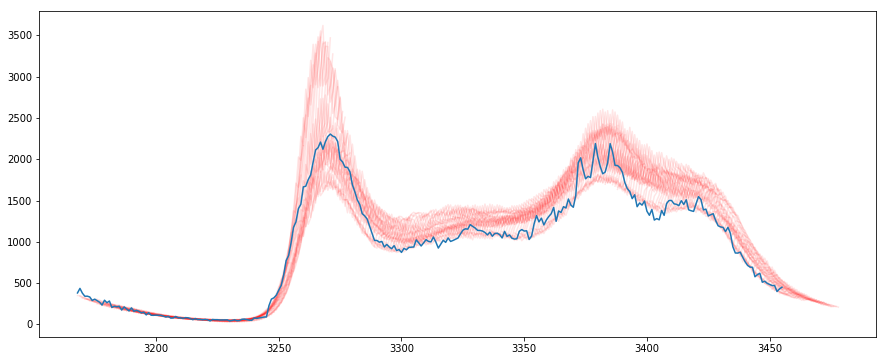

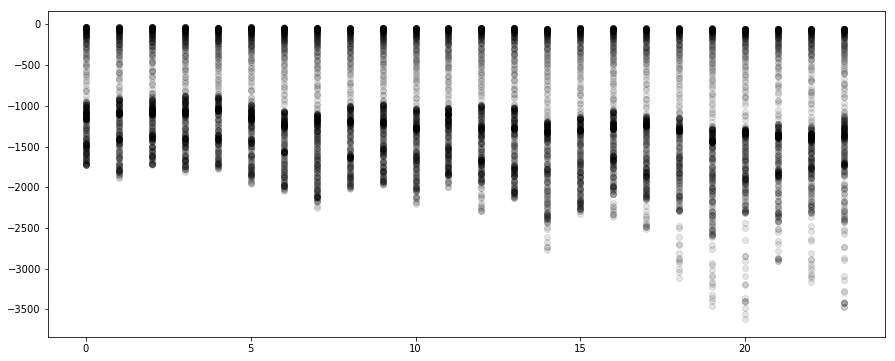

In [345]:
### np.random.seed(6)

# The interval between each dataset (original data in 5 minute intervals)
time_grouping = '5min'

# load the dataset
dataframe = pd.read_csv('ignored_assets/paxout_table.csv', engine='python', nrows=5500)
dataframe['time_bucket'] = pd.to_datetime(dataframe['time_bucket'])
dataframe = dataframe.set_index('time_bucket')
dataframe['total'] = dataframe.sum(axis=1)
dataframe['day_hour'] = dataframe.index.round(time_grouping)

# The data set with the sum of all the cars out at the 
dataframe = dataframe[['total','day_hour']].groupby('day_hour').sum()

dataset_orig = dataframe.values
dataset_orig = dataset_orig.astype('float32')

# log the dataset
dataset = np.log(dataset_orig)
dataset_max = max(dataset)
# scale the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = 288*7
test_size = len(dataset) - train_size
test, train = dataset[0:test_size,:], dataset[test_size:len(dataset)-look_forward,:]

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1, look_forward=2):
    dataX, dataY = [], []
    np.array(dataY)
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        if len(dataset[i + look_back:i+look_back+look_forward, 0]) == look_forward:
            dataX.append(a)
            dataY.append(dataset[i + look_back:i+look_back+look_forward, 0])
    return np.array(dataX), np.array(dataY)

# reshape into X=[t, t-1, t-2,..., t-look_back] and Y=[t+1, t+2,... t+look_forward]
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

def predictNext2Hours (model, dataset):
    dataset = np.array(dataset)
    # log then normalize the dataset
    dataset = np.log(dataset)
    # normalize
    
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = dataset.transpose()
    dataset = dataset.reshape(-1, 1)
    dataset = scaler.fit_transform(dataset)
    dataset = dataset.transpose()
    
    data = (dataset.T)
    data = data.reshape(1, 1, data.shape[0])
    # make a prediction
    prediction = model.predict(data)
    
    prediction = scaler.inverse_transform(prediction)
    
    prediction = np.exp(prediction)
    
    return prediction

def predict (day=11, total_days=1, delta=1, show_gradual_error=True):
    predictions = np.array([])
    true_vals = np.array([])
    for i in range (288*total_days/delta):
        # the point where the model will predict
        point = 288*day + i * delta
        prediction = predictNext2Hours (model, dataset_orig[point-look_back:point].reshape(look_back)).reshape(24)
        # plots the predictions
        plt.plot(range(point, point+24),prediction, color="red", alpha=0.1)
        
        predictions, true_vals = np.append(predictions, prediction), np.append(true_vals,dataset[i:i+24])
    # Reshapes the predictions and true vals to calculate the error
    predictions, true_vals = predictions.reshape(len(predictions)/24, 24), true_vals.reshape(len(true_vals)/24, 24)
    plt.plot( np.arange(288 * total_days) + 288 * day, dataset_orig[288*day:288*day+288*total_days,0])
    plt.show()
    if show_gradual_error:
        for i in range(look_forward):
            # calc individial errors
            indiv_err = true_vals[:,i] - predictions[:,i]
            plt.scatter(np.ones(len(indiv_err))*i,indiv_err, color='black',alpha=0.1)
        # plt.plot(err)
        plt.show()

def over_penalty(y_true, y_pred):
    true_error = y_true-y_pred
    return K.sqrt(K.square(true_error) * K.square(K.sign(true_error) - 0.4))

# create and fit the LSTM network
np.random.seed(1)
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(look_forward, input_shape=(1, look_back)))
model.add(Dense(look_forward*3))
model.add(Dense(look_forward))
model.compile(loss=over_penalty, optimizer=keras.optimizers.RMSprop(lr=0.0005, rho=0.9, epsilon=1e-08, decay=0.0002))
model.fit(trainX, trainY, epochs=5, batch_size=3, verbose=2)
predict()